# Mechanical parts recognition

Author: Y. Staeva

This project is focused on Image classification for the purpose of Mechanical parts recognition.
The following script contains the image data preprocessing and the development of a Deep Learning Convolutional Neural Network. The model evaluation is provided in a second script.

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, InputLayer, BatchNormalization, Dropout, Conv2D, MaxPool2D, GaussianNoise
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2022-01-03 11:05:06.130115: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


### GPU check

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPU available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPU available:  1


2022-01-03 11:05:07.523560: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-03 11:05:07.524159: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-03 11:05:07.583293: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-03 11:05:07.583765: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1050 computeCapability: 6.1
coreClock: 1.493GHz coreCount: 5 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 104.43GiB/s
2022-01-03 11:05:07.583806: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-01-03 11:05:07.586713: I tensorflow/stream_executor/platform/default/ds

### Read data

In [3]:
imagegen_train = ImageDataGenerator(featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
    height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
    channel_shift_range=0.0, fill_mode='nearest', cval=0.0,
    horizontal_flip=False, vertical_flip=False, rescale= 1/255,
    preprocessing_function=None, data_format='channels_last', validation_split=0.0, dtype=None)
images = imagegen_train.flow_from_directory("/home/juliana/Документи/Zusatz - Mechanical parts/MECHANICAL_PARTS/training-parts",
                                           class_mode = "categorical",
                                           shuffle = False,
                                           batch_size = 70,
                                           target_size = (224,224))

Found 5403 images belonging to 4 classes.


In [4]:
imagegen_val = ImageDataGenerator(rescale= 1/255)
images_val = imagegen_val.flow_from_directory("/home/juliana/Документи/Zusatz - Mechanical parts/MECHANICAL_PARTS/validation-parts",
                                               class_mode = "categorical",
                                               shuffle = False,
                                               batch_size = 70,
                                               target_size = (224,224))

Found 1524 images belonging to 4 classes.


### Check image shape and type

In [ ]:
import cv2 as cv
test = cv.imread("/content/drive/MyDrive/MECHANICAL_PARTS/testing-parts/bolt/00_09_0101_0100_0400_10.png")
test.shape

### Build model

In [5]:
cnn = Sequential([
                  InputLayer(input_shape=(224,224,3)),
                  Conv2D(filters = 15, kernel_size = (3,3), padding = 'valid', activation = 'relu', kernel_regularizer = l2(0.0005),strides=(2,2)),
                  MaxPool2D(pool_size=(3,3)),
                  BatchNormalization(),
                  Flatten(),
                  GaussianNoise(0.001),
                  Dense(units = 20, activation='relu', kernel_regularizer = l2(0.0005)),
                  Dropout(rate = 0.2),
                  Dense(units = 10, activation = 'relu', kernel_regularizer = l2(0.0005)),
                  Dropout(rate = 0.2),
                  Dense(units = 4, activation = 'softmax')
])

2022-01-03 11:05:13.190439: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-03 11:05:13.190766: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-03 11:05:13.191079: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1050 computeCapability: 6.1
coreClock: 1.493GHz coreCount: 5 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 104.43GiB/s
2022-01-03 11:05:13.191110: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.s

In [6]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 111, 111, 15)      420       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 37, 15)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 37, 37, 15)        60        
_________________________________________________________________
flatten (Flatten)            (None, 20535)             0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 20535)             0         
_________________________________________________________________
dense (Dense)                (None, 20)                410720    
_________________________________________________________________
dropout (Dropout)            (None, 20)                0

In [7]:
cnn.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=0.00007))

In [8]:
early_stop = EarlyStopping(monitor='val_accuracy',verbose = 1, patience = 30)
model_checkpoint = ModelCheckpoint('best_mech_cnn_2.h5', monitor = 'val_accuracy', verbose = 1, save_best_only = True)

In [9]:
r = cnn.fit(images,validation_data = (images_val), batch_size = 70, epochs = 30, callbacks=[early_stop, model_checkpoint])

2022-01-03 11:05:17.768594: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-03 11:05:17.787471: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299965000 Hz


Epoch 1/30


2022-01-03 11:05:18.167499: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-01-03 11:05:18.310784: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-01-03 11:05:18.755468: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-01-03 11:05:18.780892: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


78/78 [==============================] - 11s 120ms/step - loss: 1.4183 - accuracy: 0.2289 - val_loss: 1.3848 - val_accuracy: 0.2579

Epoch 00001: val_accuracy improved from -inf to 0.25787, saving model to best_mech_cnn_2.h5
Epoch 2/30
78/78 [==============================] - 8s 105ms/step - loss: 1.1018 - accuracy: 0.4412 - val_loss: 1.5075 - val_accuracy: 0.2500

Epoch 00002: val_accuracy did not improve from 0.25787
Epoch 3/30
78/78 [==============================] - 8s 104ms/step - loss: 0.9529 - accuracy: 0.5444 - val_loss: 1.1956 - val_accuracy: 0.4337

Epoch 00003: val_accuracy improved from 0.25787 to 0.43373, saving model to best_mech_cnn_2.h5
Epoch 4/30
78/78 [==============================] - 8s 103ms/step - loss: 0.8685 - accuracy: 0.6196 - val_loss: 1.1439 - val_accuracy: 0.4482

Epoch 00004: val_accuracy improved from 0.43373 to 0.44816, saving model to best_mech_cnn_2.h5
Epoch 5/30
78/78 [==============================] - 8s 103ms/step - loss: 0.7932 - accuracy: 0.6636 -

### Plot performance

In [10]:
import matplotlib.pyplot as plt

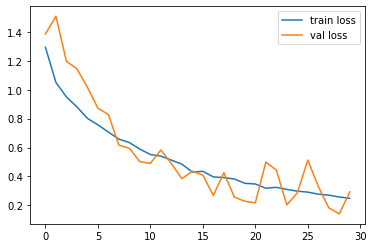

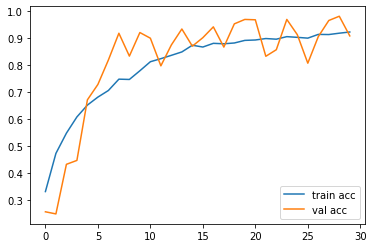

In [11]:
#plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
#plt.savefig('LossVal_loss')

#plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
#plt.savefig('AccVal_acc')